In [189]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [128]:
artists = pd.read_csv('data_by_artist.csv')
artists

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count
0,Frank Sinatra,792507,0.384478,0.238017,0.364288,110.181698,-14.271141,1,5,0.735648,0.020855,0.232106,0.049614,189179.9255,26.004383,1369
1,Vladimir Horowitz,119107,0.343210,0.118844,0.225951,94.900679,-23.193418,1,1,0.990070,0.879508,0.183812,0.043360,266541.1251,3.592378,1207
2,Johnny Cash,816890,0.619803,0.449381,0.680662,115.037747,-11.593104,1,10,0.685637,0.022647,0.242243,0.098216,162279.2672,26.614130,1104
3,Billie Holiday,79016,0.572637,0.201368,0.498934,109.912172,-13.225966,1,5,0.908499,0.013064,0.217727,0.062432,185131.4530,15.621005,1095
4,Bob Dylan,66915,0.512598,0.477932,0.551934,126.160149,-11.184330,1,7,0.562567,0.034211,0.308978,0.064535,256713.4203,30.860806,1092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,Natalie La Rose,3359519,0.830000,0.520000,0.735000,104.990000,-8.714000,1,0,0.000792,0.000013,0.065600,0.037600,189907.0000,64.000000,1
5850,Sarah Ross,3381566,0.721000,0.944000,0.626000,85.002000,-5.982000,1,8,0.013000,0.000000,0.320000,0.159000,262760.0000,52.000000,1
5851,Rotimi,3410250,0.637000,0.501000,0.431000,103.993000,-6.148000,0,0,0.229000,0.000059,0.099000,0.187000,185461.0000,71.000000,1
5852,Jillian Jacqueline,3455945,0.547000,0.672000,0.283000,155.791000,-5.023000,1,11,0.304000,0.000000,0.099600,0.049600,213133.0000,58.000000,1


In [129]:
years = pd.read_csv('data_by_year.csv')
years

,year,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity
0,1921,0.425661,0.236784,0.425495,100.397758,-17.095437,1,7,0.895823,0.322330,0.215814,0.077258,229911.9141,0.351562
1,1922,0.480000,0.237026,0.534056,101.376139,-19.179958,1,10,0.939236,0.440470,0.238647,0.115419,167904.5417,0.138889
2,1923,0.568462,0.246936,0.624788,112.456598,-14.373882,1,0,0.976329,0.401932,0.236656,0.098619,178356.3018,5.727811
3,1924,0.548654,0.347033,0.668574,120.653359,-14.202304,1,10,0.935575,0.583955,0.237875,0.090210,188461.6498,0.603376
4,1925,0.571890,0.264373,0.616430,115.671715,-14.516707,1,5,0.965422,0.408893,0.243094,0.115457,184130.6996,2.707224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016,0.599976,0.592877,0.430769,119.070344,-7.949913,1,0,0.280290,0.074646,0.180198,0.107298,219400.7638,61.371254
96,2017,0.612286,0.586739,0.414465,116.840277,-8.422697,1,1,0.289916,0.098209,0.194218,0.111752,209343.6130,64.861500
97,2018,0.664930,0.590591,0.447141,122.004325,-7.253666,1,1,0.271941,0.035948,0.171781,0.128140,200919.1190,67.276000
98,2019,0.644215,0.578796,0.465856,118.868163,-8.041738,1,1,0.289298,0.076518,0.167161,0.124799,197733.1330,69.655500


In [130]:
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
full = pd.read_csv('full_music_data.csv')
allArtists = list(artists['artist_id'])
newdict = {}

full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
floor = min(full['tempo'])
span = max(full['tempo']) - floor
full['tempo'] = [(x-floor)/span for x in full['tempo']]

last_id = 0
row = 0
for i in range(len(full)): 
    thisRow = full.iloc[i,:]
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')
full

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored)
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.06720,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.01360,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.01560,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.10800,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.27600,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103482,ZZ Top,690254,0.276,0.892,0.715,0.329693,-7.035,1,11,0.40900,0.000000,0.7140,0.0893,0,115973,33,1975,4/18/1975,Jailhouse Rock - **** Remaster
103483,ZZ Top,690254,0.700,0.592,0.906,0.450025,-10.434,1,11,0.10800,0.018400,0.1180,0.0681,0,263627,32,1976,11/29/1976,It's Only Love
103484,ZZ Top,690254,0.709,0.709,0.863,0.456977,-12.023,1,2,0.11800,0.000011,0.1250,0.0370,0,158400,31,1987,1987,Balinese
103485,ZZ Top,690254,0.552,0.651,0.533,0.661835,-10.624,0,4,0.00494,0.034900,0.1320,0.2290,0,232533,43,1992,4/13/1992,La Grange - **** Remaster


In [132]:
influence = pd.read_csv('influence_data.csv')
influence

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990
...,...,...,...,...,...,...,...,...
42765,580300,Sufjan Stevens,Pop/Rock,1990,3661738,Rosemary & Garlic,Pop/Rock,2010
42766,261309,Vybz Kartel,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010
42767,467203,Michael Jackson,R&B;,1960,3670556,Trinidad Cardona,R&B;,2010
42768,2518003,Popcaan,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010


In [7]:
names = []
for i in artists['artist_name']:
    names.append(i)
influence = influence[influence['influencer_name'].isin(names)]
influence = influence[influence['follower_name'].isin(names)]
influence = influence.reset_index(drop=True)
influence

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990
...,...,...,...,...,...,...,...,...
42747,580300,Sufjan Stevens,Pop/Rock,1990,3661738,Rosemary & Garlic,Pop/Rock,2010
42748,261309,Vybz Kartel,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010
42749,467203,Michael Jackson,R&B;,1960,3670556,Trinidad Cardona,R&B;,2010
42750,2518003,Popcaan,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010


In [8]:
influenceGraph = nx.DiGraph()

In [9]:
i = 0
while i < len(influence):
    influencer = artists[artists['artist_name'] == influence['influencer_name'][i]]
    influencer = influencer[['energy','valence', 'key', 'acousticness', 'instrumentalness', 'speechiness']]
    v1 = influencer.to_numpy()
    follower = artists[artists['artist_name'] == influence['follower_name'][i]]
    follower = follower[['energy','valence', 'key', 'acousticness', 'instrumentalness', 'speechiness']]
    v2 = follower.to_numpy()
    weight = cosine_similarity(v1, v2) * 1000
    influenceGraph.add_edge(influence['influencer_name'][i], influence['follower_name'][i], weight = weight)
    i += 1

In [15]:
influenceGraph.nodes['Bob Dylan'].degree

AttributeError: 'dict' object has no attribute 'degree'

In [133]:
idDict = {}
for i in range(len(artists)):
    idDict[artists['artist_id'][i]] = artists['artist_name'][i]

influence = pd.read_csv('influence_data.csv')
iGraph = nx.DiGraph()
for artist in artists['artist_id']:
    iGraph.add_node(artist, weight = 0)
    
for i in range(len(influence)):
    influencer = influence["influencer_id"][i]
    follower = influence['follower_id'][i]
    
    iGraph.add_edge(influencer,follower)    

arts = []
artnames = []
scores = []
for node in iGraph.nodes():
    children = list(iGraph.successors(node))
    total = 0
    for child in children:
        total += iGraph.out_degree[child]
        
    iGraph.nodes[node]['weight'] = total
    arts.append(node)
    try:
        artnames.append(idDict[node])
    except KeyError:
        artnames.append('Unknown')
    scores.append(total)
    
   
totalInfluence = pd.DataFrame({'names':artnames, 'artists':arts, 'scores':scores})
totalInfluence = totalInfluence.sort_values(by=['scores'], ascending = False)
totalInfluence[:20]

,names,artists,scores
15,The Beatles,754032,11237
4,Bob Dylan,66915,7928
5,The Rolling Stones,894465,6341
137,Chuck Berry,120521,5897
7,Elvis Presley,180228,4749
210,The Velvet Underground,840402,4380
176,Little Richard,824022,4371
147,Jimi Hendrix,354105,4312
201,Hank Williams,549797,4134
35,The Kinks,100160,4067


In [134]:
totalInfluence = totalInfluence.reset_index(drop=True)
totalInfluence

,names,artists,scores
0,The Beatles,754032,11237
1,Bob Dylan,66915,7928
2,The Rolling Stones,894465,6341
3,Chuck Berry,120521,5897
4,Elvis Presley,180228,4749
...,...,...,...
5850,Wet Wet Wet,203765,0
5851,Des'ree,206668,0
5852,David Lindley,211146,0
5853,Vixen,222748,0


In [135]:
artistStyle = full.groupby(['artist_names']).mean() #some values dont make sense to average but w/ex
artistStyle

songStats = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness']

for edge in list(iGraph.edges())[:100]: #could combine this w/weighted influence scores to see how much they actually influence
    inf = edge[0] #the musical style of the people theys upposedly influence 
    fol = edge[1]
    infstats = artistStyle[artistStyle['artists_id'] == inf][songStats]
    folstats = artistStyle[artistStyle['artists_id'] == fol][songStats]
    a = cosine_similarity(infstats, folstats)
    print(a)

[[0.91836107]]
[[0.96846749]]
[[0.99754292]]
[[0.94749496]]
[[0.97385075]]
[[0.6478513]]
[[0.9942241]]
[[0.74212613]]
[[0.98274307]]
[[0.86855959]]
[[0.99076241]]
[[0.95748195]]
[[0.90812649]]
[[0.80597076]]
[[0.98228294]]
[[0.84575681]]
[[0.98485552]]
[[0.99084487]]
[[0.95293218]]
[[0.99475058]]
[[0.96192202]]
[[0.96966828]]
[[0.90677015]]
[[0.99257806]]
[[0.80276329]]
[[0.96444635]]
[[0.91293176]]
[[0.99075153]]
[[0.98310733]]
[[0.98769665]]
[[0.76249751]]
[[0.96548011]]
[[0.94333997]]
[[0.98874487]]
[[0.92517966]]
[[0.99190568]]
[[0.99854997]]
[[0.97391353]]
[[0.96676866]]
[[0.88313195]]
[[0.96381149]]
[[0.97863503]]
[[0.94791865]]
[[0.99274143]]
[[0.92176934]]
[[0.97086445]]
[[0.98532605]]
[[0.73712951]]
[[0.99660343]]
[[0.98272712]]
[[0.96737333]]
[[0.91950685]]
[[0.96357615]]
[[0.901943]]
[[0.94282809]]
[[0.91479634]]
[[0.96625134]]
[[0.980177]]
[[0.9231327]]
[[0.99628188]]
[[0.95753862]]
[[0.99017597]]
[[0.79749341]]
[[0.99336569]]
[[0.99539963]]
[[0.94544705]]
[[0.84926009]]
[[

In [136]:
genre = []
for i in influence['influencer_main_genre']:
    if i not in genre:
        genre.append(i)
for i in influence['follower_main_genre']:
    if i not in genre:
        genre.append(i)
genre

['Pop/Rock',
 'Electronic',
 'Reggae',
 'Jazz',
 'Country',
 'Comedy/Spoken',
 'R&B;',
 'Classical',
 'Latin',
 'Vocal',
 'Folk',
 'Easy Listening',
 'International',
 'Avant-Garde',
 'Blues',
 'Stage & Screen',
 'New Age',
 'Religious',
 "Children's",
 'Unknown']

In [137]:
artistByGenre = {}
for i in genre:
    artistByGenre[i] = []
i = 0
while i < len(influence):
    genreList = artistByGenre.get(influence['influencer_main_genre'][i])
    genreListF = artistByGenre.get(influence['follower_main_genre'][i])
    if influence['influencer_name'][i] not in genreList:
        genreList.append(influence['influencer_name'][i])
    if influence['follower_name'][i] not in genreListF:
        genreListF.append(influence['follower_name'][i])
    i += 1

In [179]:
jazzSongs = full[full['artist_names'].isin(artistByGenre.get('Jazz'))]
jazzSongs = jazzSongs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
jazzMeans = jazzSongs.mean(axis=0)
jazzMeans = jazzMeans.to_numpy()

In [155]:
genreFeatures = []
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    means = means.to_numpy()
    genreFeatures.append(means)

In [171]:
i = 0
jazzsim = []
while i < len(genre):
    sim = cosine_similarity(jazzMeans.reshape(1, -1), genreFeatures[i].reshape(1, -1))
    jazzsim.append(sim[0][0])
    i += 1

In [173]:
d = {'Genre' : genre, 'Cosine Similarity' : jazzsim}
jazzSimilarity = pd.DataFrame(data=d)
jazzSimilarity = jazzSimilarity.sort_values(by=['Cosine Similarity'], ascending = False)
jazzSimilarity = jazzSimilarity.reset_index(drop=True)
jazzSimilarity

,Genre,Cosine Similarity
0,Jazz,1.000000
1,Avant-Garde,0.999892
2,Easy Listening,0.999821
3,Folk,0.999606
4,Stage & Screen,0.998424
5,Vocal,0.998347
6,Comedy/Spoken,0.997561
7,Classical,0.996964
8,New Age,0.996319
9,International,0.995279


In [202]:
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    print(i)
    print(means['tempo'])

Pop/Rock
0.5041980713608971
Electronic
0.49042630707112583
Reggae
0.4774755289800211
Jazz
0.462278082020503
Country
0.4900360207138811
Comedy/Spoken
0.43481045095581794
R&B;
0.47720687330073297
Classical
0.4364707118746228
Latin
0.4904744919256894
Vocal
0.4515249429416114
Folk
0.4755359158889776
Easy Listening
0.4548916454260138
International
0.4750882932243574
Avant-Garde
0.45780935105224024
Blues
0.4824690364704632
Stage & Screen
0.4256400818155745
New Age
0.4554467713904153
Religious
0.4926720395705324
Children's
0.4874728923340553
Unknown
0.49486651100803203


In [182]:
RBSongs = full[full['artist_names'].isin(artistByGenre.get('R&B;'))]
RBSongs = RBSongs.sort_values(by='year')
RBSongs = RBSongs.reset_index(drop=True)
RBSongs

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored)
0,Aretha Franklin,927555,0.496,0.829,0.733,0.487597,-8.876,0,5,0.6290,0.076800,0.162,0.0519,0,161893,0,1927,1927,Evil **** ***** - Live
1,Screamin' Jay Hawkins,309458,0.845,0.455,0.896,0.356433,-13.668,0,5,0.7100,0.420000,0.055,0.0488,0,145933,2,1927,1927,I Put A Spell On You - Live
2,Chuck Willis,126144,0.556,0.476,0.730,0.700698,-6.766,1,10,0.9590,0.002400,0.242,0.0778,0,132733,0,1932,1932,Take It Like A Man (with The Royals)
3,Aretha Franklin,927555,0.648,0.356,0.529,0.355339,-13.917,0,7,0.8960,0.000036,0.110,0.0837,0,186160,3,1936,1936,It Ain't Necessarily So - from ***** and Bess
4,Babyface,61226,0.400,0.408,0.143,0.567764,-8.039,0,0,0.7710,0.013000,0.114,0.0286,0,287853,2,1941,1941,Strange Fruit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10954,Ashanti,933898,0.768,0.635,0.640,0.659557,-4.925,1,10,0.0289,0.000000,0.312,0.1500,1,215053,71,2020,4/17/2020,NASTY (feat. Ashanti & Megan Thee Stallion)
10955,Kehlani,3226468,0.824,0.503,0.784,0.448181,-6.940,0,6,0.0500,0.000053,0.107,0.1560,0,185419,67,2020,1/28/2020,Get Me
10956,Kehlani,3226468,0.832,0.508,0.750,0.447997,-6.913,0,6,0.0492,0.000054,0.107,0.1490,0,185427,71,2020,2/14/2020,Get Me (feat. Kehlani)
10957,The Weeknd,2674162,0.689,0.374,0.321,0.622637,-10.038,0,5,0.1150,0.000132,0.111,0.0851,1,144540,74,2020,4/3/2020,Missed You - Bonus Track


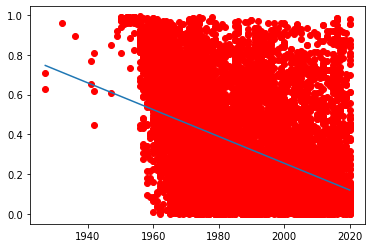

In [201]:
year = RBSongs['year']
loudness = RBSongs['acousticness']
plt.plot(year, loudness, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, loudness, 1))(np.unique(year)))

In [222]:
jazzRoots = influence[['influencer_name', 'follower_main_genre']]
jazzRoots = jazzRoots[jazzRoots['follower_main_genre'] == 'Jazz']
jazzRoots = pd.DataFrame(jazzRoots['influencer_name'].value_counts(ascending=False))
jazzRoots = jazzRoots.reset_index()
jazzRoots = jazzRoots.rename(columns={'index': 'Influencer', 'influencer_name': 'Number of Jazz Followers'})
jazzRoots

,Influencer,Number of Jazz Followers
0,Miles Davis,83
1,Charlie Parker,78
2,John Coltrane,66
3,Dizzy Gillespie,46
4,Lester Young,45
...,...,...
476,Johnny Mandel,1
477,Chic,1
478,Patti Austin,1
479,Jimmy Giuffre,1


In [218]:
AGroots = influence[['influencer_name', 'follower_main_genre']]
AGroots = AGroots[AGroots['follower_main_genre'] == 'Avant-Garde']
AGRoots = pd.DataFrame(AGroots['influencer_name'].value_counts(ascending=False))
AGRoots

,influencer_name
John Cage,6
Terry Riley,3
Philip Glass,2
Moondog,2
Brian Eno,2
Harold Budd,1
Maria Callas,1
Funkadelic,1
John Cale,1
Giorgio Moroder,1


In [219]:
ELroots = influence[['influencer_name', 'follower_main_genre']]
ELroots = ELroots[ELroots['follower_main_genre'] == 'Easy Listening']
ELroots = pd.DataFrame(ELroots['influencer_name'].value_counts(ascending=False))
ELroots

,influencer_name
Les Baxter,4
Liberace,3
Martin Denny,3
AntÃ´nio Carlos Jobim,2
Percy Faith,2
George Shearing,2
Paul Weston,1
Melissa Etheridge,1
Billy Joel,1
Mannheim Steamroller,1
